In [2]:
import geopandas as gpd
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os
from tqdm import tqdm
import IPython.display as display
import copy
import seaborn as sns

/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/1k/27mkp8bj3ps60c3nmr7rbqzh0000gn/T/ipykernel_33589/1895528008.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch shou

In [3]:
def merge_csv_files(directory):
    # Get a list of all the csv files
    csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

    # Initialize an empty list to hold dataframes
    dfs = []

    # Loop through csv files, read each into a dataframe, and append to the list
    for file in csv_files:
        # Extract date from filename, assuming the date is in format 'traffic_flow_YYYY_MM_DD'
        date_str = file.split('.')[0].split('_')[-3:]  # This gives ['YYYY', 'MM', 'DD']
        date = datetime.strptime('_'.join(date_str), '%Y_%m_%d').date()

        df = pd.read_csv(os.path.join(directory, file))

        # Add date as a new column
        df['date'] = date.strftime('%m/%d/%y')

        dfs.append(df)

    # Concatenate all dataframes in the list into one dataframe
    merged_df = pd.concat(dfs, ignore_index=True).drop_duplicates()

    # Return the merged dataframe
    return merged_df

In [4]:
traffic_flows = merge_csv_files(
    '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Raw data/[XH]Traffic flow')
road_network = '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Raw data/[XH]road_network/road_network.shp'

# clean the traffic flow data
traffic_flows = traffic_flows.drop_duplicates(['toid', 'date'])
traffic_flows = traffic_flows.groupby(['toid', 'date']).agg(
    {'bus': 'sum', 'car': 'sum', 'cycle': 'sum', 'walks': 'sum', 'stationary': 'sum'}).reset_index()

road_network = gpd.read_file(road_network, crs={'init': 'epsg:27700'})

In [5]:
lsoa = '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Raw data/London administrative boundaries/london_LSOA/london_LSOA.shp'
road_network = '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Raw data/[XH]road_network/road_network.shp'
inoutter = '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Raw data/London administrative boundaries/lp-consultation-oct-2009-inner-outer-london-shp/lp-consultation-oct-2009-inner-outer-london.shp'
tube_line = 'https://raw.githubusercontent.com/oobrien/vis/master/tubecreature/data/tfl_lines.json'
tube_station = 'https://raw.githubusercontent.com/oobrien/vis/master/tubecreature/data/tfl_stations.json'

inoutter = gpd.read_file(inoutter)
inoutter.to_crs(epsg=27700, inplace=True)

tube_station = gpd.read_file(tube_station)
tube_station.to_crs(epsg=27700, inplace=True)
tube_station = gpd.sjoin(tube_station, inoutter, op='within')

tube_line = gpd.read_file(tube_line)
tube_line.to_crs(epsg=27700, inplace=True)
tube_line = gpd.sjoin(tube_line, inoutter, op='within')

lsoa = gpd.read_file(lsoa, crs={'init': 'epsg:27700'})
road_network = gpd.read_file(road_network, crs={'init': 'epsg:27700'})

/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [6]:
# clean the traffic flow data
traffic_flows = traffic_flows.drop_duplicates(['toid', 'date'])
traffic_flows = traffic_flows.groupby(['toid', 'date']).agg(
    {'bus': 'sum', 'car': 'sum', 'cycle': 'sum', 'walks': 'sum', 'stationary': 'sum'}).reset_index()

In [7]:
flows = pd.merge(
    road_network[['toid', 'roadclassi', 'routehiera', 'geometry',
                  'directiona', 'length', 'roadwidthm', 'elevationg'
                  ]],
    traffic_flows, left_on='toid', right_on='toid', how='right')

# Perform the aggregation to road network level
cycle = traffic_flows.pivot(index='toid', columns='date', values='cycle')

cycle = pd.merge(road_network[['toid', 'roadclassi', 'routehiera', 'geometry',
                               'directiona', 'length', 'roadwidthm', 'elevationg']],
                 cycle,
                 left_on='toid', right_on='toid', how='left').reset_index()
# obtain the date columns
date_columns = cycle.columns[cycle.columns.str.contains('/')]

# Calculate the difference between each date column
for i, col in enumerate(date_columns[1:], 1):
    diff_col_name = f'diff_{col}'
    cycle[diff_col_name] = cycle[date_columns[i]] - cycle[date_columns[i - 1]]

# Calculate the sum and the difference weekly
week_sums = cycle[date_columns].rolling(window=7, axis=1).sum().iloc[:, 6::7]
week_sums.rename(columns={col: f'sum_week_{i}' for i, col in enumerate(week_sums.columns, 1)}, inplace=True)

In [8]:
cycle = pd.concat([cycle, week_sums], axis=1)
cycle['diff_week_1&2'] = cycle['sum_week_2'] - cycle['sum_week_1']
cycle['diff_week_2&3'] = cycle['sum_week_3'] - cycle['sum_week_2']

# re classify the road class
# print(cycle['roadclassi'].unique())
# ['Unknown' 'Not Classified' 'Unclassified' 'B Road' 'A Road' 'Classified Unnumbered' 'Motorway']
# print(cycle['directiona'].unique())
# ['bothDirections' 'inOppositeDirection' 'inDirection']

cycle['classification'] = cycle['roadclassi'].replace(
    {'Unknown': 'Other', 'Not Classified': 'Other', 'Unclassified': 'Other', 'Classified Unnumbered': 'Other'})
cycle.drop(columns=['roadclassi', 'index', 'routehiera'], inplace=True)

In [9]:
flows_gdf = cycle

In [10]:
# 创建一个空的无向图
graph = nx.Graph()

# 遍历 'flows' 数据，添加节点和边
for index, row in flows_gdf.iterrows():
    from_node = row['geometry'].coords[0]  # 路的起点
    to_node = row['geometry'].coords[-1]  # 路的终点
    flow = row['diff_03/01/22']  # Link 的权重，即 Flows
    direction = row['directiona']  # Flow direction

    # Add nodes to the graph
    graph.add_node(from_node, pos=from_node)  # Use 'from_node' as the node position
    graph.add_node(to_node, pos=to_node)  # Use 'to_node' as the node position
    # Add edges to the graph based on the direction
    if direction == 'bothDirections':
        # If the road is bidirectional, flows are split equally in both directions
        graph.add_edge(from_node, to_node, weight=flow / 2,
                       toid=row['toid'], classification=row['classification'], geometry=row['geometry'])
        graph.add_edge(to_node, from_node, weight=flow / 2,
                       toid=row['toid'], classification=row['classification'], geometry=row['geometry'])
    elif direction == 'inOppositeDirection':
        # If the road is in the opposite direction, flows are from the ending point to the starting point
        graph.add_edge(to_node, from_node, weight=flow,
                       toid=row['toid'], classification=row['classification'], geometry=row['geometry'])
    elif direction == 'inDirection':
        # If the road is in the same direction, flows are from the starting point to the ending point
        graph.add_edge(from_node, to_node, weight=flow,
                       toid=row['toid'], classification=row['classification'], geometry=row['geometry'])


In [12]:
# 获取图中的所有边的列表
edges_list = list(graph.edges())

# 确保图中至少有一条边
if edges_list:
    # 获取第一条边的起始节点和目标节点
    u, v = edges_list[0]

    # 获取第一条边的属性
    edge_attr = graph[u][v]

    print(f"The first edge：({u}, {v})")
    print("Attribute：", edge_attr)
else:
    print("No edge in the graph.")

The first edge：((508760.52699999977, 191314.76099999994), (508800.6950000003, 191280.45910000056))
Attribute： {'weight': -1.0, 'toid': 'osgb4000000030327667', 'classification': 'Other', 'geometry': <LINESTRING (508760.527 191314.761, 508770 191314, 508773 191314, 508788 191...>}


In [14]:
# Sort edges based on their weight (flow) in descending order
sorted_edges = sorted(graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

# Take the top 10% of edges with the highest flow
top_10_edges = sorted_edges[:int(len(sorted_edges) * 0.1)]

# Convert the edge tuples to a list of tuples containing only node names
top_10_edges_nodes = [(u, v) for u, v, _ in top_10_edges]

# Specify the desired 'classification' attribute values to display
desired_classifications = ['Motorway', 'A Road', 'B Road', 'Other']

4it [00:34,  8.50s/it]


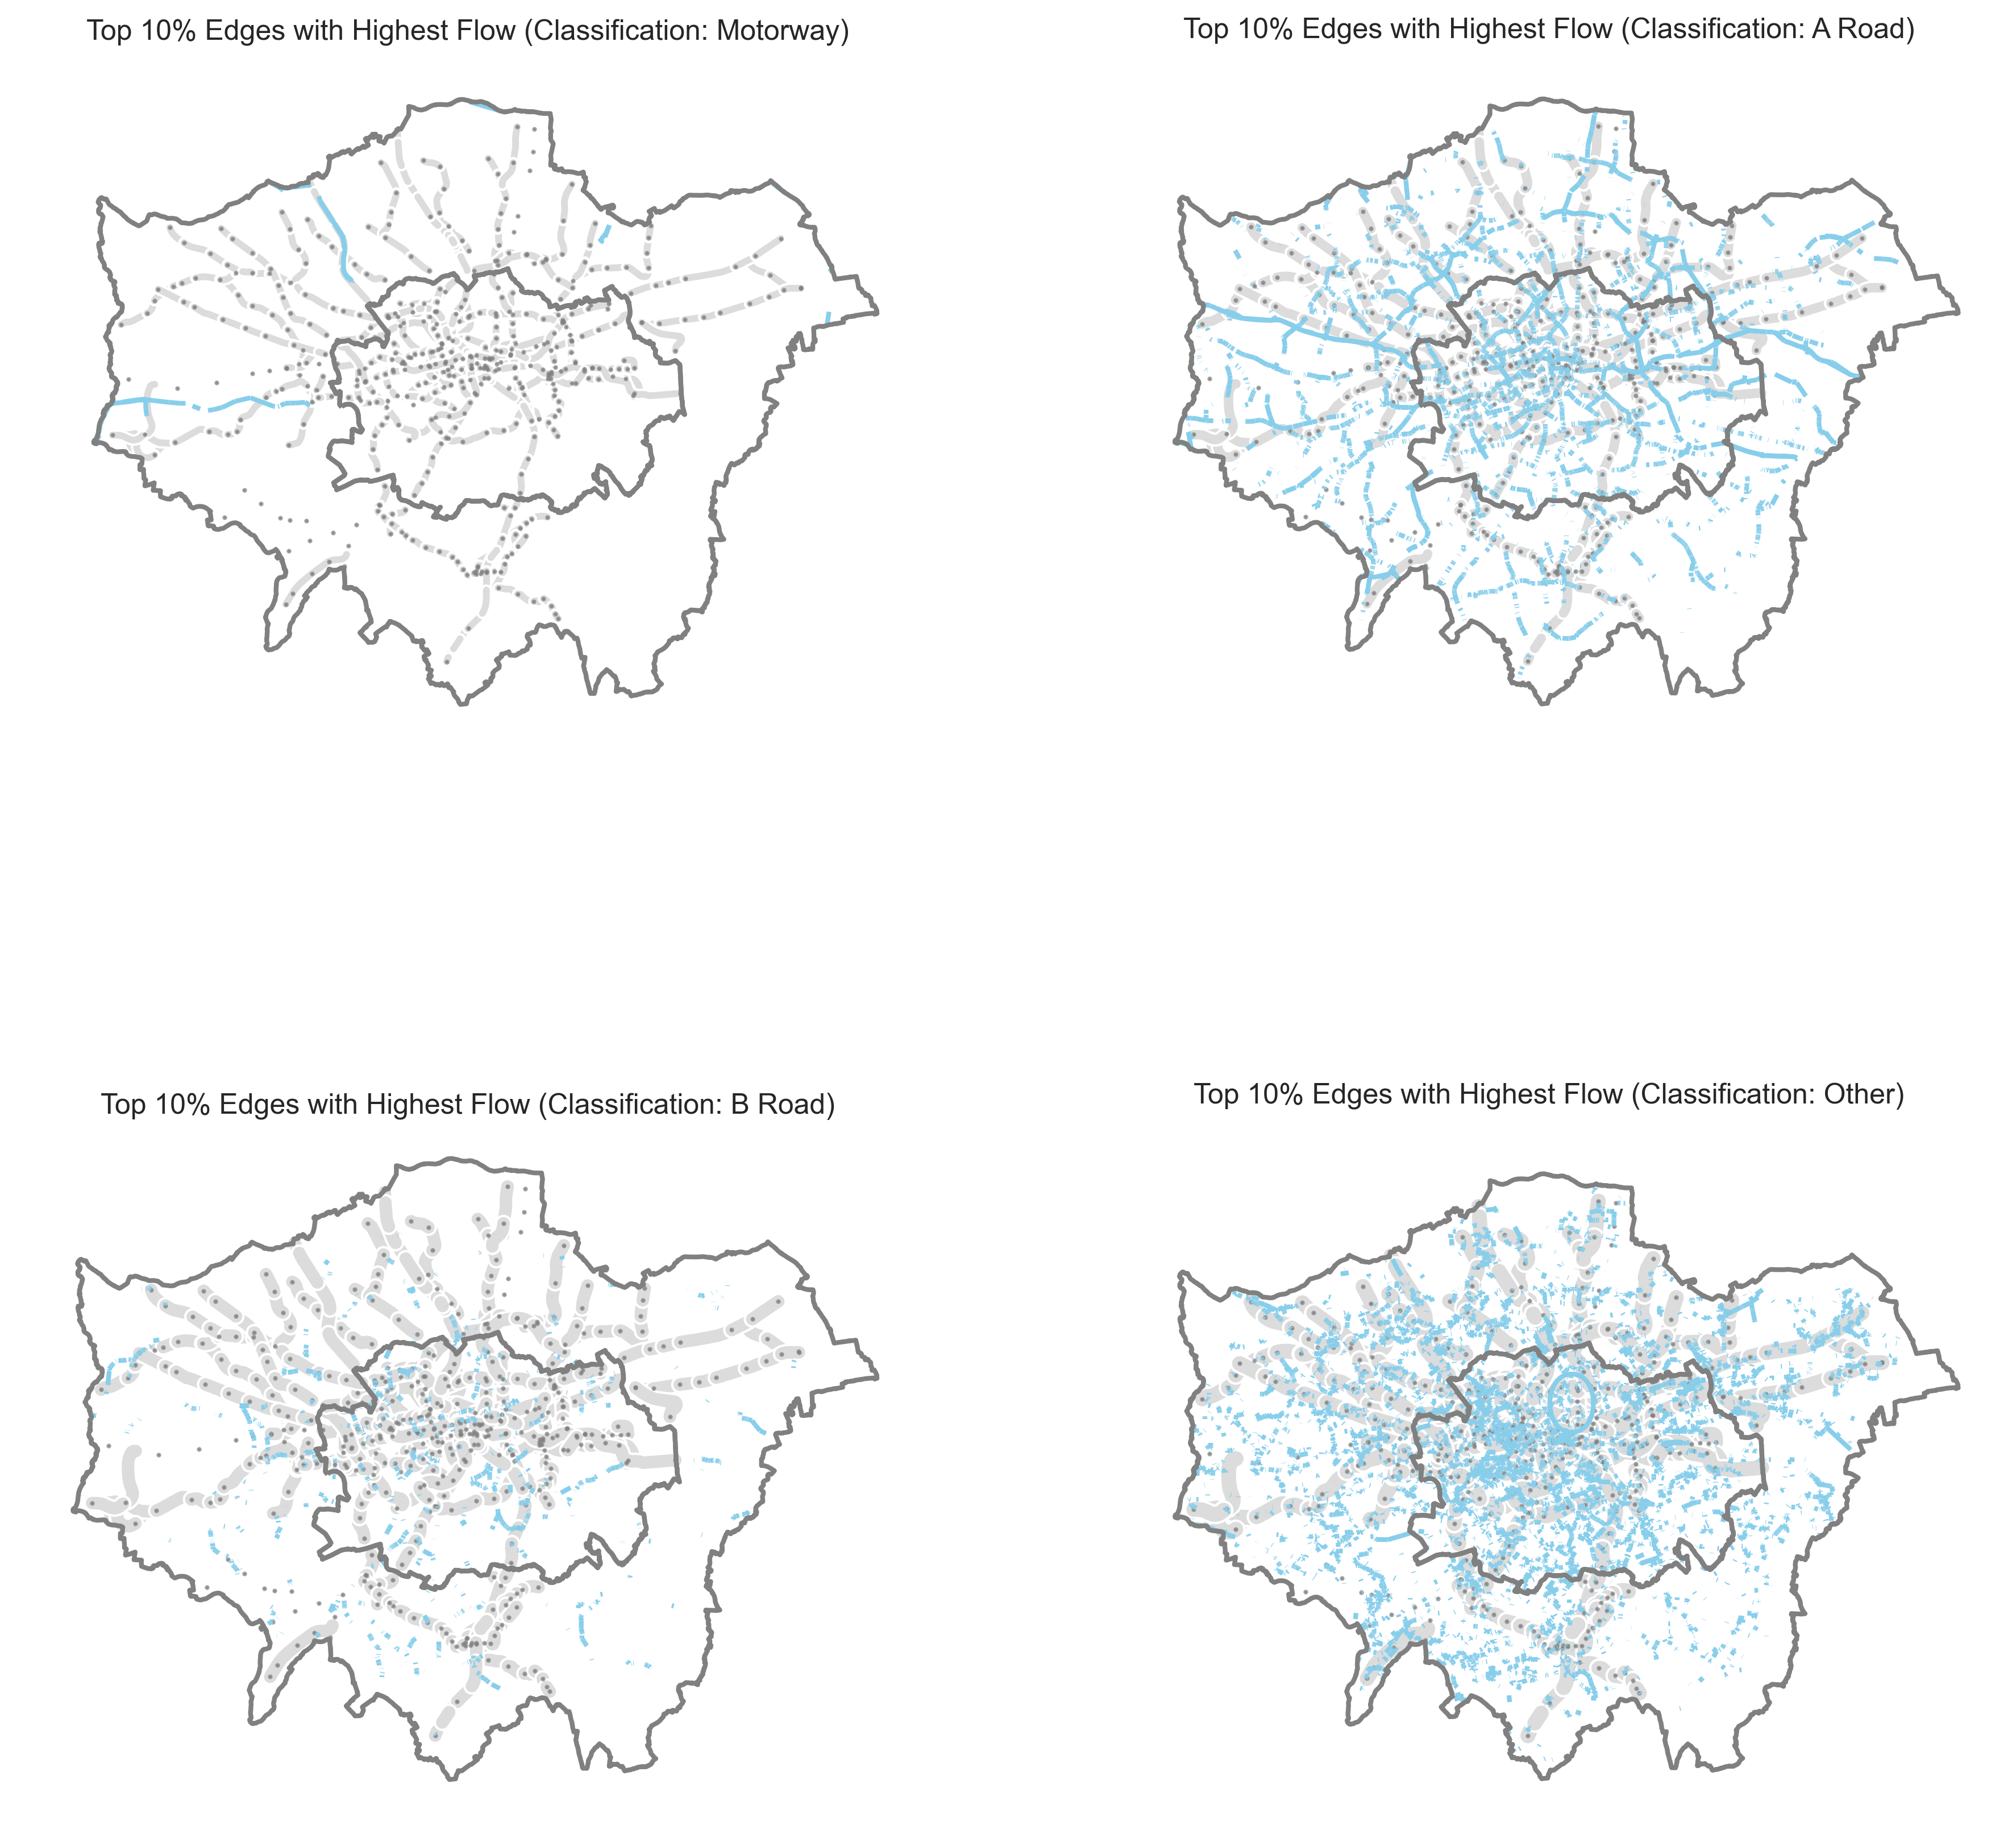

In [17]:
# Create a new figure and axis for the sub-plots
fig, axs = plt.subplots(2, 2, figsize=(15, 15), dpi=300)

# Loop through each desired classification and plot the corresponding subgraph
for i, desired_classification in tqdm(enumerate(desired_classifications)):
    # Create a subgraph containing only the top 10% edges with the specified 'classification'
    subgraph = graph.edge_subgraph(
        [(u, v) for u, v in top_10_edges_nodes if graph[u][v]['classification'] == desired_classification])

    # Get the positions of nodes using the 'pos' attribute
    node_positions = nx.get_node_attributes(subgraph, 'pos')

    # Add a subplot for each desired classification
    ax1 = axs[i // 2, i % 2]

    # plot the background map
    inoutter.boundary.plot(color='gray', ax=ax1, linewidth=2)
    tube_line['geometry'] = tube_line.geometry.buffer(100)
    tube_line.plot(color='gainsboro', ax=ax1, legend=True)
    tube_station.plot(color='gray', alpha=0.7, ax=ax1, legend=True, markersize=1, )

    try:
        # Draw edges
        nx.draw_networkx_edges(subgraph, pos=node_positions, width=2, edge_color='skyblue', ax=ax1)

        # Set the graph title and axis visibility
        ax1.set_title(f'Top 10% Edges with Highest Flow (Classification: {desired_classification})')
        ax1.axis('off')

    except Exception as e:
        print(f"An error occurred for the classification '{desired_classification}': {e}")

# Display the plots
plt.show()

In [ ]:
# Create a subgraph containing all edges
subgraph_all = graph.edge_subgraph(top_10_edges_nodes)

# Get the positions of nodes using the 'pos' attribute for the subgraph containing all edges
node_positions_all = nx.get_node_attributes(subgraph_all, 'pos')

# Add a subplot for the fourth plot to show all road classifications
fig, ax2 = plt.subplots(figsize=(12, 10))
ax2.set_title('All Road Classifications')
ax2.axis('off')

# plot the background map
inoutter.boundary.plot(color='gray', ax=ax2, linewidth=2)

# Loop through all edges in the subgraph containing all edges
for u, v, data in tqdm(subgraph_all.edges(data=True)):
    classification = data['classification']
    # Set different colors based on the 'classification' attribute
    edge_color = 'skyblue' if classification == 'Motorway' else 'green' if classification == 'A Road' else 'orange' if classification == 'B Road' else 'gray'
    # Draw each edge with the corresponding color
    nx.draw_networkx_edges(subgraph_all, pos=node_positions_all, edgelist=[(u, v)], edge_color=edge_color, width=2,
                           alpha=0.7, ax=ax2)

ax2.legend(['Motorway', 'A Road', 'B Road', 'Other'], loc='lower right')
# Display the plots
plt.show()

 49%|████▉     | 13748/27948 [1:05:46<1:26:18,  2.74it/s]  

In [33]:
# Calculate the weighted betweenness centrality for all edges in the graph
betweenness_centrality_weighted = nx.edge_betweenness_centrality(graph, weight='weight')

# Sort the edges based on their weighted betweenness centrality in descending order
sorted_edges = sorted(betweenness_centrality_weighted.items(), key=lambda x: x[1], reverse=True)

# Get the top 10% edges
top_10_edges = sorted_edges[:int(len(graph.edges()) * 0.1)]

# Create a new directed graph 'top_10_graph' containing only the top 10% edges
top_10_graph = nx.DiGraph()

for (u, v), betweenness_centrality in top_10_edges:
    # Retrieve edge attributes from the original graph
    edge_attributes = graph[u][v]

    # Set the 'flows' attribute to the 'weight' value from the 'edge_attributes' dictionary
    top_10_graph.add_edge(u, v, flows=edge_attributes['weight'], toid=edge_attributes['toid'],
                          classification=edge_attributes['classification'], geometry=edge_attributes['geometry'],
                          bcw=betweenness_centrality)

# Visualize the graph with only the top 10% edges
pos = nx.spring_layout(top_10_graph, seed=42)

plt.figure(figsize=(15, 12))

# Draw edges with width proportional to the 'betweenness_centrality_weighted' attribute
edge_widths = [top_10_graph.edges[u, v]['bcw'] for u, v in top_10_graph.edges()]
nx.draw_networkx_edges(top_10_graph, pos, edge_color='skyblue', width=edge_widths, arrows=True)

# # Set node labels based on the 'betweenness_centrality_weighted' attribute
# node_labels = {node: f"{node} ({top_10_graph.nodes[node]['bcw']:.4f})" for node in top_10_graph.nodes}
# nx.draw_networkx_labels(top_10_graph, pos, labels=node_labels, font_size=8)

# Add colorbar for edge flows
flows_values = [data['flows'] for _, _, data in top_10_graph.edges(data=True)]
norm = plt.Normalize(min(flows_values), max(flows_values))
cmap = plt.cm.get_cmap('viridis')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Edge Flows', orientation='horizontal', shrink=0.6, pad=0.01)

# Set plot title and axis visibility
plt.title('Top 10% Edges with Highest Weighted Betweenness Centrality')
plt.axis('off')

# Show the plot
plt.show()


KeyboardInterrupt: 

In [ ]:
# Create a function to compute the number of connected components in the network after node removal
def count_connected_components(G):
    G_copy = copy.deepcopy(G)
    return len(list(nx.connected_components(G_copy)))


# Create a function to compute the size of the largest connected component in the network after node removal
def size_largest_component(G):
    G_copy = copy.deepcopy(G)
    components = list(nx.connected_components(G_copy))
    largest_component = max(components, key=len)
    return len(largest_component)


def global_efficiency(G):
    G_copy = copy.deepcopy(G)
    return nx.global_efficiency(G_copy)


def edge_centrality_removal(G, centrality_measure, num_edges=10):
    G_removal = copy.deepcopy(G)

    # Compute centrality measure for all edges in the network
    edge_centrality = centrality_measure(G_removal)

    # Create a DataFrame with edges and their centrality scores
    edges_df = pd.DataFrame(list(edge_centrality.items()), columns=['edge', 'centrality'])

    # Sort edges by their centrality score
    edges_sorted = edges_df.sort_values(by='centrality', ascending=False)

    # Initialize lists to store the impact measures for each edge removal
    num_components = []
    largest_component_size = []
    num_components.append(count_connected_components(G_removal))
    largest_component_size.append(size_largest_component(G_removal))

    # Remove edges in order of decreasing centrality score and compute impact measures
    for i in range(min(num_edges, len(edges_sorted))):
        edge = edges_sorted.iloc[i]['edge']
        G_copy = copy.deepcopy(G_removal)
        G_copy.remove_edge(*edge)
        num_components.append(count_connected_components(G_copy))
        largest_component_size.append(size_largest_component(G_copy))

    return num_components, largest_component_size, num_edges


def count_connected_components(G):
    return nx.number_connected_components(G)


def size_largest_component(G):
    return len(max(nx.connected_components(G), key=len))
